# LOOPBACK TESTER

This notebook is useful for loopback tests when you have some Borealis data you would like to verify. This notebook is built off of the original test_beamforming.py script that I wrote in Nov/Dec 2018 to verify beamforming algorithms in Borealis. However, these analyses are useful to verify data after any update to the Borealis code. What follows is a list of functions that I plan to build into this script. - Marci Detwiller Feb 2019

**If only release-mode data is available for a given time, this notebook will:**
1. Plot the time domain data, or a portion of the data 
2. Verify location of the pulses in the data and pulse length
3. Plot the frequency spectrum and find the peaks 
4. Verify the beamforming if antennas_iq is available

**If debug-mode data is available (rawrf, txdata, stage_1_iq, etc.), this notebook will also:**
1. Verify the rawrf from the txdata
2. Find the peaks of the FFT in the rawrf data and compare to the bfiq data to verify the decimation




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import deepdish
import numpy as np
import random
import traceback

sys.path.append('../plot_borealis_hdf5_data/')
from plotting_borealis_data_utils import *
#from sample_building.sample_building import get_phshift, shift_samples
sys.path.append(os.environ['BOREALISPATH'])
from tools.testing_utils.beamforming_utils import *

In [2]:
# Change the filename to whichever file contains your loopback data
filename = '/data/borealis_data/20210610/20210610.1812.57.inv.0.bfiq.hdf5.site'
data_file = os.path.basename(filename)
data_directory = os.path.dirname(filename) # get directory outside of the data (/data/borealis_data)

record_name = None  # or change if you want a specific record 

In [3]:
# get the corresponding data files to this data file, including antennas_iq, bfiq,
# rawrf, txdata if available.

data_file_metadata = data_file.split('.')

date_of_file = data_file_metadata[0]
timestamp_of_file = '.'.join(data_file_metadata[0:3])
station_name = data_file_metadata[3]
slice_id_number = data_file_metadata[4]

file_suffix = data_file_metadata[-1]

if file_suffix not in ['hdf5', 'site']:
    raise Exception('Incorrect File Suffix: {}'.format(file_suffix))

if file_suffix == 'hdf5':
    type_of_file = data_file_metadata[-2]  # XX.hdf5
else:
    type_of_file = data_file_metadata[-3]  # XX.hdf5.site    
    
if type_of_file == slice_id_number:
    slice_id_number = '0'  # choose the first slice to search for other available files.
else:
    type_of_file = slice_id_number + '.' + type_of_file


antennas_iq_filetype = slice_id_number + ".antennas_iq"
bfiq_filetype = slice_id_number + ".bfiq"
stage_1_filetype = slice_id_number + ".stage_1_iq"
stage_2_filetype = slice_id_number + ".stage_2_iq"
stage_3_filetype = slice_id_number + ".stage_3_iq"
# stage 4 = antennas_iq so unnecessary
rawrf_filetype = "rawrf"
tx_filetype = "txdata"
file_types_avail = [bfiq_filetype, antennas_iq_filetype, tx_filetype, rawrf_filetype, 
                    stage_1_filetype, stage_2_filetype, stage_3_filetype]

if type_of_file not in file_types_avail:
    raise Exception(
        'Data type: {} not incorporated in script. Allowed types: {}'.format(type_of_file,
                                                                             file_types_avail))

data = {}
print('Available Filetypes: ')
for file_type in list(file_types_avail):  # copy of file_types_avail so we can modify it within.
    try:
        filename = data_directory + '/' + timestamp_of_file + \
                    '.' + station_name + '.' + file_type + '.hdf5.site'
        data[file_type] = deepdish.io.load(filename)
        print(file_type)
    except:
        file_types_avail.remove(file_type)
        if file_type == type_of_file:  # if this is the filename you provided.
            raise

Available Filetypes: 
0.bfiq
0.antennas_iq
txdata
rawrf


In [4]:
# Choose a record from the provided file, and get that record for each filetype to analyze side by side.
# Also reshaping data to correct dimensions - if there is a problem with reshaping, we will also not use that record.

good_record_found = False
record_attempts = 0
    
while not good_record_found:
    if record_name is None:
        record_name = random.choice(list(data[type_of_file].keys()))
    print('Record Name Chosen: {}'.format(record_name))
    record_data = {}
    
    try:
        for file_type in file_types_avail:
            record_data[file_type] = data[file_type][record_name]

            if file_type == bfiq_filetype:
                bf_iq = record_data[bfiq_filetype]

            if file_type == antennas_iq_filetype:
                antennas_iq = record_data[antennas_iq_filetype]

            if file_type == rawrf_filetype:
                rawrf = record_data[rawrf_filetype]

            # tx data does not need to be reshaped.
            if file_type == tx_filetype:
                tx = record_data[tx_filetype]

    except ValueError as e:
        print('Record {} raised an exception in filetype {}:\n'.format(record_name, file_type))
        traceback.print_exc()
        print('\nA new record will be selected.')
        record_attempts +=1
        if record_attempts == 3:
            print('FILES FAILED WITH 3 FAILED ATTEMPTS TO LOAD RECORDS.')
            raise # something is wrong with the files 
    except KeyError as e:
        print('Record {} is not in filetype {}:\n'.format(record_name, file_type))
        traceback.print_exc()
        print('\nA new record will be selected.')
        record_attempts += 1
        if record_attempts == 3:
            print('FILES FAILED WITH 3 FAILED ATTEMPTS TO LOAD RECORDS.')
            raise # something is wrong with the files 
    else:  # no errors
        good_record_found = True

if bfiq_filetype not in file_types_avail:
    raise Exception('BFIQ data is required to do tests and could not be loaded.')

Record Name Chosen: 1623348777823


In [5]:
print("Attributes:")
print(record_data[bfiq_filetype].keys())
print("\nData Descriptors:")
print(record_data[bfiq_filetype]['data_descriptors'])

Attributes:
dict_keys(['antenna_arrays_order', 'beam_azms', 'beam_nums', 'blanked_samples', 'data', 'data_descriptors', 'data_dimensions', 'lags', 'noise_at_freq', 'pulse_phase_offset', 'pulses', 'sqn_timestamps', 'borealis_git_hash', 'data_normalization_factor', 'experiment_comment', 'experiment_id', 'experiment_name', 'first_range', 'first_range_rtt', 'freq', 'int_time', 'intf_antenna_count', 'main_antenna_count', 'num_ranges', 'num_samps', 'num_sequences', 'num_slices', 'range_sep', 'rx_sample_rate', 'samples_data_type', 'scan_start_marker', 'scheduling_mode', 'slice_comment', 'slice_id', 'slice_interfacing', 'station', 'tau_spacing', 'tx_pulse_len'])

Data Descriptors:
['num_antenna_arrays' 'num_sequences' 'num_beams' 'num_samps']


Sequence number: 0
Antennas: ['antenna_0', 'antenna_1', 'antenna_2', 'antenna_3', 'antenna_4', 'antenna_5', 'antenna_6', 'antenna_7', 'antenna_8', 'antenna_9', 'antenna_10', 'antenna_11', 'antenna_12', 'antenna_13', 'antenna_14', 'antenna_15', 'antenna_16', 'antenna_17', 'antenna_18', 'antenna_19']


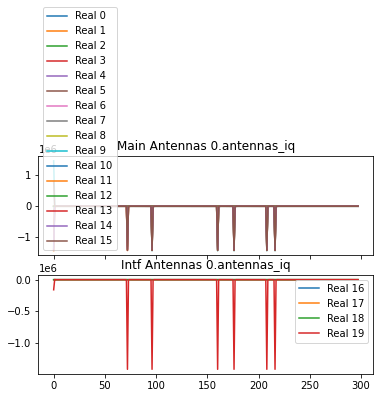

Blanked Samples:
[  0  72  96 160 176 208 216]

Antenna 0: Pulse locations verified - Rx matches Tx
Antenna 1: Pulse locations verified - Rx matches Tx
Antenna 2: Pulse locations verified - Rx matches Tx
Antenna 3: Pulse locations verified - Rx matches Tx
Antenna 4: Pulse locations verified - Rx matches Tx
Antenna 5: Pulse locations verified - Rx matches Tx
Antenna 6: Received pulses did not match transmitted pulses
	Pulses: [72, 96, 160, 166, 176, 208, 216]	Threshold: 0.55
Antenna 7: Pulse locations verified - Rx matches Tx
Antenna 8: Pulse locations verified - Rx matches Tx
Antenna 9: Pulse locations verified - Rx matches Tx
Antenna 10: Pulse locations verified - Rx matches Tx
Antenna 11: Pulse locations verified - Rx matches Tx
Antenna 12: Pulse locations verified - Rx matches Tx
Antenna 13: Pulse locations verified - Rx matches Tx
Antenna 14: Pulse locations verified - Rx matches Tx
Antenna 15: Pulse locations verified - Rx matches Tx
Antenna 16: Pulse locations verified - Rx match

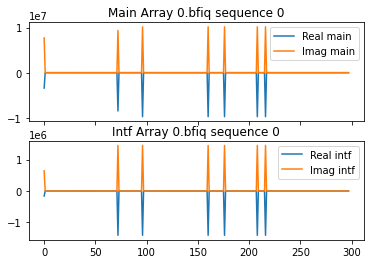

In [6]:
if stage_1_filetype in file_types_avail:
    plot_antennas_iq_data(record_data[stage_1_filetype], stage_1_filetype)
if stage_2_filetype in file_types_avail:
    plot_antennas_iq_data(record_data[stage_2_filetype], stage_2_filetype)
if stage_3_filetype in file_types_avail:
    plot_antennas_iq_data(record_data[stage_3_filetype], stage_3_filetype)

#print(antennas_iq)
plot_antennas_iq_data(antennas_iq, antennas_iq_filetype)

#print(antennas_iq)
num_antennas = len(antennas_iq['antenna_arrays_order'])
blanks = antennas_iq['blanked_samples']

print('Blanked Samples:')
print('{}\n'.format(blanks))

step = 0.0125
# Verify the received pulses match the transmitted pulses for each antenna
for antenna in range(num_antennas):
    threshold = 0.25    # Noise floor for finding normalized pulses
    num_tries = 0
    rx_pulses = 0
    passed = False
    while rx_pulses != len(blanks):
        pulses = find_pulse_indices(antennas_iq['data'][antenna][0], threshold)
        rx_pulses = len(pulses)
        
        # Missing pulses, lower the threshold
        if rx_pulses < len(blanks):
            if threshold - step < step:
                break
            threshold -= step
            num_tries += 1
        
        # Extra pulses, increase the threshold
        elif rx_pulses > len(blanks):
            threshold += step
            num_tries += 1
        
        # Same number of pulses as tx
        else:
            passed = True
            
        if num_tries == 25:
            break
    
    if passed:
        # Check that the received pulses are indeed the same as the transmitted ones.
        for pulse in pulses:
            if pulse not in blanks:
                passed = False
    # The pulses definitely match, so it was a success!
    if passed:
        print('Antenna {}: Pulse locations verified - Rx matches Tx'.format(antenna))
    else:
        print('Antenna {}: Received pulses did not match transmitted pulses'.format(antenna))
        print('\tPulses: {}\tThreshold: {}'.format(pulses, threshold))
        
plot_bf_iq_data(bf_iq, bfiq_filetype)

# We should see pulses in loopback data. We should see only noise perhaps with some leakage
# if a channel is not connected (i.e. intf channels in loopback tests)

In [7]:
if tx_filetype in file_types_avail:
    print(record_data[tx_filetype]['dm_rate'])

[1500]


Sequence number: 0
Beam number: 0
Sequence number: 0
Antennas: ['antenna_0', 'antenna_1', 'antenna_2', 'antenna_3', 'antenna_4', 'antenna_5', 'antenna_6', 'antenna_7', 'antenna_8', 'antenna_9', 'antenna_10', 'antenna_11', 'antenna_12', 'antenna_13', 'antenna_14', 'antenna_15', 'antenna_16', 'antenna_17', 'antenna_18', 'antenna_19']
Antenna 0 Peaks:
[]

Antenna 1 Peaks:
['-1251.40', '-836.14', '-409.65', '5.61', '420.88', '847.36', '1262.63']

Antenna 2 Peaks:
[]

Antenna 3 Peaks:
[]

Antenna 4 Peaks:
[]

Antenna 5 Peaks:
[]

Antenna 6 Peaks:
[]

Antenna 7 Peaks:
['-1251.40', '-824.92', '-409.65', '5.61', '420.88', '847.36', '1262.63']

Antenna 8 Peaks:
['-1251.40', '-836.14', '-409.65', '5.61', '420.88', '847.36', '1262.63']

Antenna 9 Peaks:
['-1240.18', '-824.92', '-409.65', '5.61', '432.10', '847.36', '1262.63']

Antenna 10 Peaks:
[]

Antenna 11 Peaks:
[]

Antenna 12 Peaks:
[]

Antenna 13 Peaks:
['-1251.40', '-836.14', '-409.65', '5.61', '420.88', '847.36', '1262.63']

Antenna 14 Pe

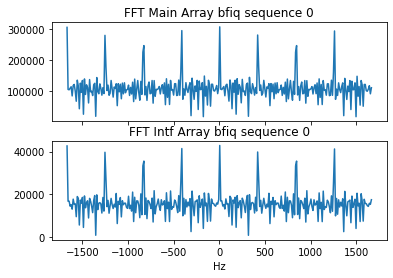

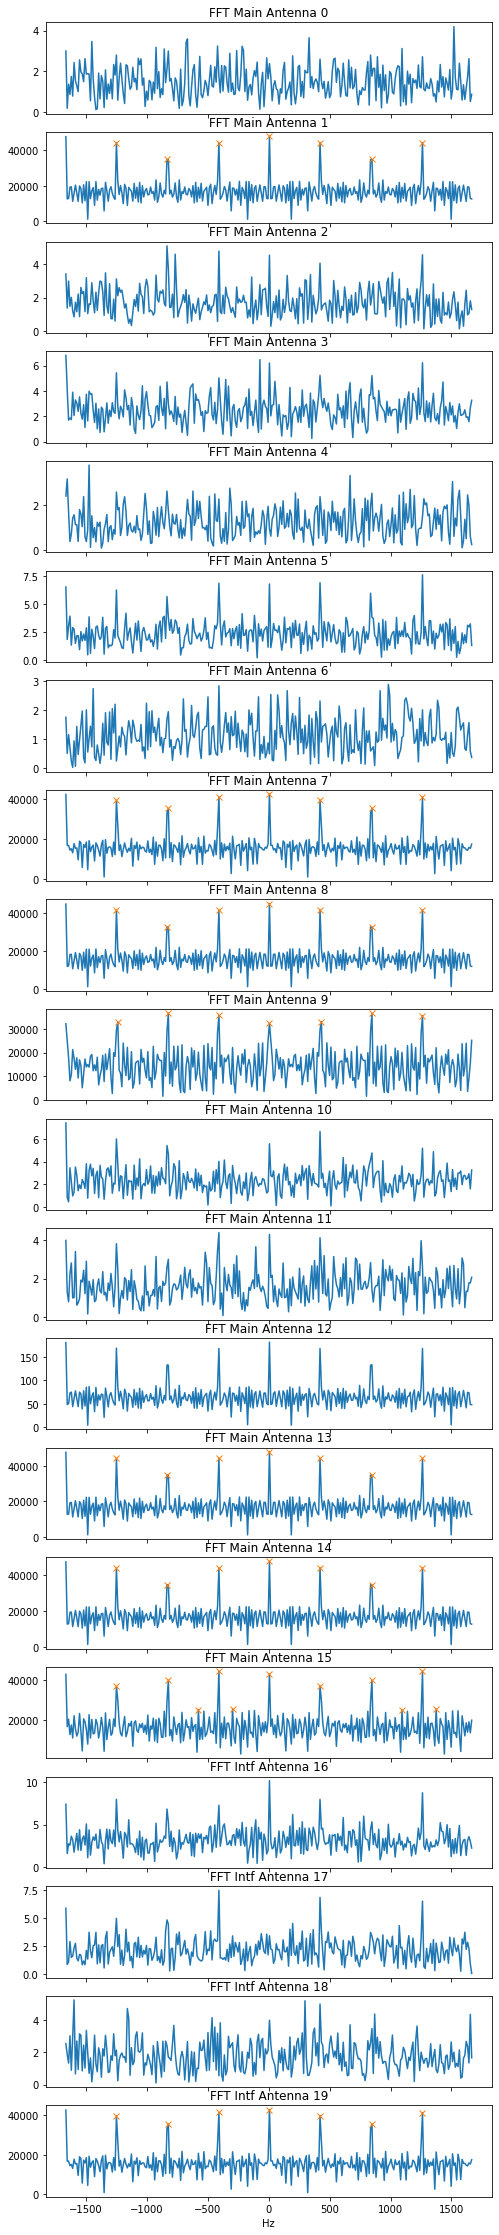

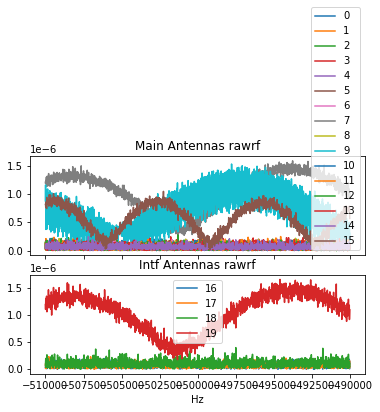

/home/radar/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


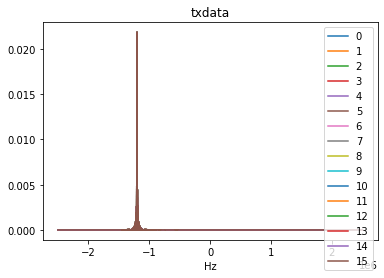

In [8]:
# In loopback data, we expect to see the peak of the FFT at our transmitted frequency. We expect to see 
# other peaks at 666.6 Hz off of the txfreq, because this is the periodicity of our signal (1.5ms = tau)

# These two should always be available
fft_samps, xf, fig = fft_and_plot_bfiq_data(record_data[bfiq_filetype], 'bfiq')
fft_samps, xf, fig = fft_and_plot_antennas_iq(record_data[antennas_iq_filetype], 'antennas_iq')

if stage_1_filetype in file_types_avail:
    fft_samps, xf, fig = fft_and_plot_antennas_iq(record_data[stage_1_filetype], 'stage 1', plot_width=50)
if stage_2_filetype in file_types_avail:
    fft_samps, xf, fig = fft_and_plot_antennas_iq(record_data[stage_2_filetype], 'stage 2', plot_width=100)
if stage_3_filetype in file_types_avail:
    fft_samps, xf, fig = fft_and_plot_antennas_iq(record_data[stage_3_filetype], 'stage 3')
if rawrf_filetype in file_types_avail:
    fft_and_plot_rawrf_data(record_data[rawrf_filetype], 'rawrf', plot_width=20000, start_sample=0, end_sample=-1, center=-500000)
if tx_filetype in file_types_avail:
    fft_and_plot_txdata(record_data[tx_filetype], 'txdata')
plt.show()

Decimation rate error: [0.]
3333
Sequence number: 0
Sample number 0 to 3000


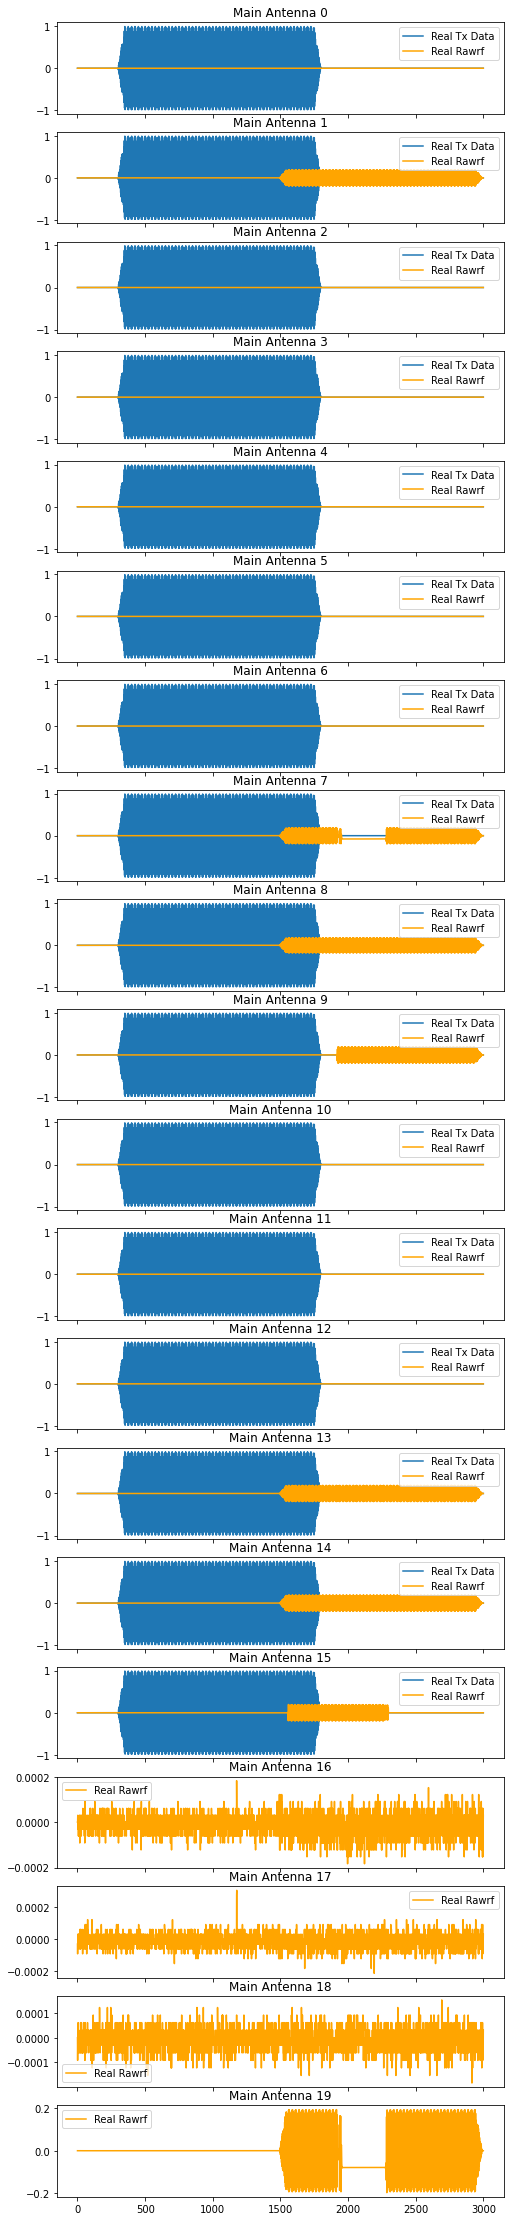

In [9]:
# Plot the tx and rawrf data together. This function plots the same channels together,
# so make sure to plug Tx 1 into Rx 1, Tx 2 into Rx 2, and so forth to minimize
# confusion. As you can see, it is confusing if you don't!
if 'rawrf' in file_types_avail and 'txdata' in file_types_avail:
    plot_rawrf_tx(rawrf, tx, start_sample=0, end_sample=3000)